#### Code of Bayer (2019) is used in part, found in https://github.com/bstemper/deep_rough_calibration

In [1]:
import pandas as pd
import numpy as np
import datetime

import scipy.stats as stats
import emcee
import corner
import pymc3 as pm

import sys
sys.path.append('src')
from src import helperfunctions as hf
from src import SABR
from src.SABR_IV_approximators import Hagan, AntonovApprox, AntonovANN
from src.classes import DataImporter

import matplotlib.pyplot as plt

save_path = r"C:\Users\hugo\OneDrive\Documents\Quantitative Finance\Thesis\Plots"

data_importer = DataImporter()

DATA_PATH = r'C:\Users\hugo\OneDrive\Documents\Quantitative Finance\Thesis\Data\training_data'

network_approximator = AntonovANN()

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected ! Aesara will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
smile = data_importer.smile_days(20200504, 30, extra_cols=['volume'], n_strikes=25)
smile['spread'] = smile['best_offer'] - smile['best_bid']
# correct the spread to have the same order of magnitude as sigma of a simulated smile with 30 days to maturity
multiplier = .001 / smile.loc[0, 'spread']
smile['sigma'] = smile['spread'] * multiplier
smile = smile.reset_index(drop=True)
# smile

In [3]:
smile['strike_price'] = smile['strike']
smile['forward_price'] = 1

In [4]:
beta = .5
hagan = SABR.calibrate_smile(smile, Hagan(), beta=beta,strike_price=False)
hagan[0].x

array([ 0.27733308, -0.72261548,  3.18804601])

In [5]:
ann = SABR.calibrate_smile(smile, network_approximator, beta=beta,strike_price=False)
ann[0].x

array([ 0.27874229, -0.79467868,  3.60838934])

In [11]:
def compute_mean(theta, smile, approximator, beta=0.5):
    alpha, rho, v = theta
    T = smile['T'][0]
    
    return SABR.get_fit(approximator, alpha, beta, rho, v, T, smile).values


def log_prior(theta_sabr, T):
    bounds = {
        'alpha':[0, 10],
        'rho':[-1,1],
        'v':[0,20]
    }

    sum_prior = np.sum([stats.uniform.logpdf(theta_sabr[i], loc=bounds[key][0], scale=bounds[key][1] - bounds[key][0]) for i, key in enumerate(bounds)])
    
    return sum_prior
    
def log_likelihood(theta_sabr, smile, approximator, beta):
    mean = compute_mean(theta_sabr, smile, approximator, beta)
    sigma = smile['sigma'].values
    y = smile['impl_volatility'].values
    
    sigma = sigma * np.eye(len(y))
    
    logpdf = stats.multivariate_normal.logpdf(y, mean=mean, cov=sigma)
    
    return logpdf
    
def log_posterior(theta, smile, approximator, beta):
    T = smile['T'][0]
    theta_sabr = theta
    
    lp = log_prior(theta_sabr, T)

    if not np.isfinite(lp):
        return -np.inf

    result = lp + log_likelihood(theta_sabr, smile, approximator, beta)

    return result 

# Calculates the bounds used in the corner.py plots for both Hagan and ANN
def get_bounds(sample_total, quantiles=[.05,.95], offset_pct=.05):
    dim = np.shape(sample_total)[1]
        
    output = []
    for i in range(dim):
        sample = sample_total[:,i]
        q = np.quantile(sample, quantiles)
        lb = q.min()
        ub = q.max()
        
        offset = offset_pct * (ub - lb)
        output.append((lb - offset, ub + offset))
        
    return output


# Combines the bounds from get_bounds to get the optimal bounds for the corner.py plots
def get_optimal_bounds(samples, quantiles=[.05,.95], offset_pct=.05):
    bounds_list = [get_bounds(sample, quantiles, offset_pct) for sample in samples]
    output = []
    max_i = len(bounds_list[0])
    for i in range(max_i):
        lbs = [bounds[i][0] for bounds in bounds_list]
        ubs = [bounds[i][1] for bounds in bounds_list]
        output.append((min(lbs), max(ubs)))
            
    return output


In [7]:
def MCMC_sampler(approximator, ref_param, smile, n_walkers=50, n_burn=250, n_steps=600):
    n_dim = 3  # number of parameters
    
    np.random.seed(0)
    
    # random start
    pos = [ref_param + 1e-3 * np.random.randn(n_dim) for i in range(n_walkers)]

    sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior,args=(smile,approximator,0.5))
    sampler.run_mcmc(pos, n_burn + n_steps)
    
    return sampler

## Hagan

In [8]:
sampler_hagan = MCMC_sampler(Hagan(), hagan[0].x, smile)
print("Mean acceptance fraction: {0:.3f}"
      .format(np.mean(sampler_hagan.acceptance_fraction)))
flat_samples_hagan = sampler_hagan.get_chain(discard=100, thin=15, flat=True)
flat_samples_hagan = flat_samples_hagan[:,0:3]

Mean acceptance fraction: 0.648


## Antonov ANN

In [9]:
sampler_antonov = MCMC_sampler(network_approximator, ann[0].x, smile)
print("Mean acceptance fraction: {0:.3f}"
      .format(np.mean(sampler_antonov.acceptance_fraction)))
flat_samples_antonov = sampler_antonov.get_chain(discard=100, thin=15, flat=True)
flat_samples_antonov = flat_samples_antonov[:,0:3]

Mean acceptance fraction: 0.641


## Plots

In [12]:
# calculate bounds of the plots
quantiles = [.95, .05]
rng = get_optimal_bounds([flat_samples_hagan,flat_samples_antonov], quantiles=quantiles)
nbins = 25 

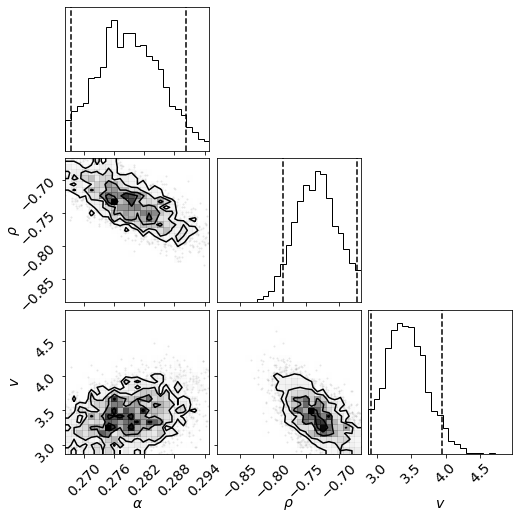

In [13]:
plt.rcParams.update({'font.size': 14})
fig = corner.corner(flat_samples_hagan, labels=[r'$\alpha$', r'$\rho$', r'$v$'],quantiles=quantiles,bins=nbins, range=rng)#, range=[(lb*alpha, ub*alpha), (-1,0), (lb*v,ub*v)])
# plt.savefig(save_path + '/bayesian_corner_spx_hagan.eps', bbox_inches='tight')

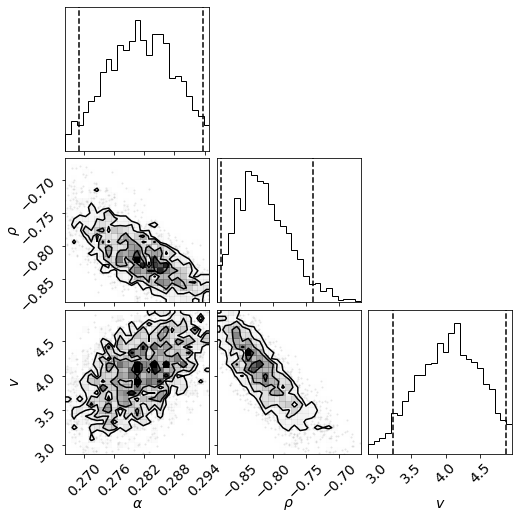

In [14]:
fig = corner.corner(flat_samples_antonov[:,0:3], labels=[r'$\alpha$', r'$\rho$', r'$v$'],bins=nbins,quantiles=quantiles, range=rng)
# plt.savefig(save_path + '/bayesian_corner_spx_ann.eps', bbox_inches='tight')

### Save the samples to a pickle for the delta/vega calculations

In [ ]:
# pd.DataFrame(flat_samples_hagan, columns=['alpha', 'rho', 'v']).to_pickle(DATA_PATH + '/samples_hagan_spx.pkl')
# pd.DataFrame(flat_samples_antonov, columns=['alpha', 'rho', 'v']).to_pickle(DATA_PATH + '/samples_antonov_spx.pkl')